# Natural Language Processing: Approccio Classico e Deep Learning

## Introduzione

Il **Natural Language Processing (NLP)** e' il campo dell'AI che
permette ai computer di comprendere, interpretare e generare
linguaggio umano.

### Applicazioni NLP

- **Analisi sentiment**: opinioni su prodotti, brand
- **Chatbot e assistenti virtuali**: Siri, Alexa, ChatGPT
- **Traduzione automatica**: Google Translate
- **Summarization**: riassunti automatici
- **Named Entity Recognition**: estrazione nomi, luoghi, organizzazioni
- **Question Answering**: sistemi di Q&A
- **Text generation**: scrittura creativa, code generation

### Evoluzione NLP

```
1950s: Regole linguistiche manuali
1990s: Statistical NLP (n-grams, HMM)
2013:  Word2Vec (embeddings)
2017:  Transformers (Attention is All You Need)
2018:  BERT (bidirectional pre-training)
2020:  GPT-3 (175B parametri)
2022:  ChatGPT (conversational AI)
2023+: LLM multimodali (GPT-4, Claude)
```

### Sfide del NLP

1. **Ambiguita'**: "Il pollo e' pronto da mangiare" (chi mangia?)
2. **Contesto**: "Fa freddo qui" (temperatura o atmosfera?)
3. **Idiomi e sarcasmo**: "Che bella giornata!" (sotto la pioggia)
4. **Variabilita' linguistica**: dialetti, slang, errori
5. **Conoscenza del mondo**: richiede common sense

---

## Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP librerie
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Download NLTK data
for resource in [
    'punkt', 'stopwords', 'wordnet',
    'punkt_tab', 'omw-1.4',
]:
    nltk.download(resource, quiet=True)

np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Using device: {device}")
print("Setup completato")

import os, urllib.request, joblib

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', '')
WEIGHTS_DIR = 'pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return None
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return None
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    return history

---

# PARTE 1: NLP CLASSICO

## 1. Preprocessing del Testo

Il preprocessing e' fondamentale in NLP per standardizzare
il testo.

### 1.1 Operazioni Base

In [2]:
# Testo di esempio
testo_esempio = """
Natural Language Processing (NLP) e' FANTASTICO!
Permette ai computer di comprendere il linguaggio umano.
Nel 2023, i modelli come GPT-4 hanno rivoluzionato il campo.
Email: info@example.com, URL: https://example.com
"""

print("Testo originale:")
print(testo_esempio)


def preprocess_text(
    text,
    remove_stopwords=True,
    apply_stemming=False,
    apply_lemmatization=True,
):
    """Pipeline completa di preprocessing."""
    # 1. Lowercase
    text = text.lower()

    # 2. Rimozione URL
    text = re.sub(
        r'http\S+|www\S+|https\S+', '',
        text, flags=re.MULTILINE,
    )

    # 3. Rimozione email
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Rimozione menzioni e hashtag (social media)
    text = re.sub(r'@\w+|#\w+', '', text)

    # 5. Rimozione numeri
    text = re.sub(r'\d+', '', text)

    # 6. Rimozione punteggiatura
    text = text.translate(
        str.maketrans('', '', string.punctuation)
    )

    # 7. Tokenization
    tokens = word_tokenize(text)

    # 8. Rimozione stopwords
    if remove_stopwords:
        # NB: using English stopwords - this pipeline is designed for English text
        stop_words = set(stopwords.words('english'))
        tokens = [
            w for w in tokens if w not in stop_words
        ]

    # 9. Stemming o Lemmatization
    if apply_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(w) for w in tokens]
    elif apply_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # 10. Rimozione token troppo corti
    tokens = [w for w in tokens if len(w) > 2]

    return ' '.join(tokens)


# Test
testo_processato = preprocess_text(testo_esempio)
print("Testo dopo preprocessing:")
print(testo_processato)

originale_len = len(testo_esempio.split())
processato_len = len(testo_processato.split())
print(f"\nLunghezza originale: {originale_len} parole")
print(f"Lunghezza processata: {processato_len} parole")

Testo originale:

Natural Language Processing (NLP) e' FANTASTICO!
Permette ai computer di comprendere il linguaggio umano.
Nel 2023, i modelli come GPT-4 hanno rivoluzionato il campo.
Email: info@example.com, URL: https://example.com

Testo dopo preprocessing:
natural language processing nlp fantastico permette computer comprendere linguaggio umano nel modelli come gpt hanno rivoluzionato campo email url

Lunghezza originale: 28 parole
Lunghezza processata: 19 parole


**Differenza Stemming vs Lemmatization:**

- **Stemming**: taglia suffissi (veloce ma meno preciso)
  - "running" -> "run"
  - "better" -> "better" (non riconosce "good")
- **Lemmatization**: trova la forma base dizionariale
  (lento ma preciso, con il POS tag corretto)
  - "running" -> "run"
  - "better" -> "good"
  - "was" -> "be"

> **Nota**: WordNetLemmatizer richiede il POS tag corretto per
> risultati accurati (default: noun). Senza il POS tag appropriato,
> "better" non verra' lemmatizzato a "good".

### 1.2 Dataset: IMDB Movie Reviews

Useremo recensioni di film per sentiment analysis
(positivo/negativo). Questo dataset sara' usato in tutto
il notebook, sia nel tutorial che negli esercizi.

In [3]:
# Caricamento dataset IMDB
from datasets import load_dataset

# Carica IMDB da Hugging Face datasets
imdb_dataset = load_dataset('imdb')

X_train_text = np.array(imdb_dataset['train']['text'])
y_train_imdb = np.array(imdb_dataset['train']['label'])
X_test_text = np.array(imdb_dataset['test']['text'])
y_test_imdb = np.array(imdb_dataset['test']['label'])

# Shuffle training e test set (il dataset HuggingFace
# e' ordinato per label, la versione Keras era shuffled)
rng = np.random.RandomState(42)
train_shuffle = rng.permutation(len(X_train_text))
X_train_text = X_train_text[train_shuffle]
y_train_imdb = y_train_imdb[train_shuffle]

test_shuffle = rng.permutation(len(X_test_text))
X_test_text = X_test_text[test_shuffle]
y_test_imdb = y_test_imdb[test_shuffle]

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Visualizza esempi
print("\nReview 1 (Positiva):")
pos_idx = np.where(y_train_imdb == 1)[0][0]
print(X_train_text[pos_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[pos_idx] == 1 else 'Negativo'}"
)
print("\n" + "=" * 60 + "\n")

# Trova una review negativa
neg_idx = np.where(y_train_imdb == 0)[0][0]
print("Review 2 (Negativa):")
print(X_train_text[neg_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[neg_idx] == 1 else 'Negativo'}"
)

print(f"\nDataset: {len(X_train_text)} train, "
      f"{len(X_test_text)} test")
print(f"Esempio: {X_train_text[0][:200]}...")

Training samples: 25000
Test samples: 25000

Review 1 (Positiva):
I dug out from my garage some old musicals and this is another one of my favorites. It was written by Jay Alan Lerner and directed by Vincent Minelli. It won two Academy Awards for Best Picture of 1951 and Best Screenplay. The story of an American painter in Paris who tries to make it big. Nina Foch is a sophisticated lady of means and is very interested in helping him, but soon finds she loves the guy. Meanwhile Gene Kelly falls for lovely damsel, Leslie Caron. His main dancing partner, and I m

Sentiment: Positivo


Review 2 (Negativa):
Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version of "The Three Amigos", only without any laughs. In order for black comedy to work, it must be outrageous, which "Play Dead" is not. In order for black comedy to work, it cannot be mean spi

## Esercizio 1

**Task**: Implementare una pipeline di preprocessing
e confrontare stemming vs lemmatization su review IMDB reali.
Analizzare l'impatto del preprocessing sul vocabolario.

In [4]:
# =========================================================
# ESERCIZIO 1: Pipeline di Preprocessing
# =========================================================
# Variabili con prefisso ex1_ per evitare conflitti

# Subset di 200 review IMDB per analisi preprocessing
ex1_reviews = X_train_text[:200].copy()
ex1_labels = y_train_imdb[:200].copy()

print(f"Esercizio 1 - Dataset: {len(ex1_reviews)} review")
print(f"Distribuzione: "
      f"pos={sum(ex1_labels==1)}, "
      f"neg={sum(ex1_labels==0)}")

# Step 1: Funzioni di preprocessing specializzate
ex1_stemmer = PorterStemmer()
ex1_lemmatizer = WordNetLemmatizer()
ex1_stop_words = set(stopwords.words('english'))


def ex1_preprocess(text, method='lemma'):
    """
    Preprocessing con scelta stemming/lemmatization.
    method: 'raw', 'stem', 'lemma'
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(
        str.maketrans('', '', string.punctuation)
    )
    tokens = word_tokenize(text)
    tokens = [
        w for w in tokens
        if w not in ex1_stop_words and len(w) > 2
    ]

    if method == 'stem':
        tokens = [ex1_stemmer.stem(w) for w in tokens]
    elif method == 'lemma':
        tokens = [ex1_lemmatizer.lemmatize(w) for w in tokens]

    return ' '.join(tokens)


# Step 2: Applica i 3 metodi e confronta
ex1_methods = ['raw', 'stem', 'lemma']
ex1_processed = {}

for method in ex1_methods:
    ex1_processed[method] = [
        ex1_preprocess(r, method=method)
        for r in ex1_reviews
    ]

# Step 3: Analisi vocabolario
print("\n" + "=" * 60)
print("CONFRONTO METODI DI PREPROCESSING")
print("=" * 60)

for method in ex1_methods:
    all_words = ' '.join(ex1_processed[method]).split()
    vocab = set(all_words)
    print(f"\n{method.upper()}:")
    print(f"  Vocabolario: {len(vocab)} parole uniche")
    print(f"  Token totali: {len(all_words)}")
    print(f"  Esempio: {ex1_processed[method][0][:80]}...")

# Step 4: Confronto su stessa frase
print("\n" + "=" * 60)
print("CONFRONTO SU STESSA REVIEW")
print("=" * 60)
ex1_sample = X_train_text[0][:200]
print(f"\nOriginale: {ex1_sample}...")
for method in ex1_methods:
    result = ex1_preprocess(ex1_sample, method=method)
    print(f"{method.upper()}: {result[:80]}...")

# Step 5: Riduzione vocabolario
print("\n" + "=" * 60)
print("RIDUZIONE VOCABOLARIO")
print("=" * 60)
ex1_raw_vocab = len(
    set(' '.join(ex1_processed['raw']).split())
)
for method in ['stem', 'lemma']:
    method_vocab = len(
        set(' '.join(ex1_processed[method]).split())
    )
    reduction = (
        (ex1_raw_vocab - method_vocab) / ex1_raw_vocab * 100
    )
    print(
        f"{method.upper()}: {method_vocab} parole "
        f"(-{reduction:.1f}% vs raw)"
    )

print("\nEsercizio 1 completato")

Esercizio 1 - Dataset: 200 review
Distribuzione: pos=95, neg=105

CONFRONTO METODI DI PREPROCESSING

RAW:
  Vocabolario: 7280 parole uniche
  Token totali: 22429
  Esempio: dumb dumb thoroughly uninteresting supposed black comedy essentially starts chri...

STEM:
  Vocabolario: 5625 parole uniche
  Token totali: 22429
  Esempio: dumb dumb thoroughli uninterest suppos black comedi essenti start chri klein tri...

LEMMA:
  Vocabolario: 6689 parole uniche
  Token totali: 22429
  Esempio: dumb dumb thoroughly uninteresting supposed black comedy essentially start chris...

CONFRONTO SU STESSA REVIEW

Originale: Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version...
RAW: dumb dumb thoroughly uninteresting supposed black comedy essentially starts chri...
STEM: dumb dumb thoroughli uninterest suppos black comedi essenti start chri klein tri...
LEM

---

## 2. Feature Extraction Classica

### 2.1 Bag of Words (BOW)

Rappresenta il testo come vettore di frequenze delle parole,
ignorando ordine e grammatica.

In [5]:
# Esempio semplice di BOW
testi_esempio = [
    "I love this movie",
    "This movie is great",
    "I hate this movie",
]

# CountVectorizer per BOW
vectorizer_bow = CountVectorizer()
bow_matrix = vectorizer_bow.fit_transform(testi_esempio)

# Visualizzazione
vocab = vectorizer_bow.get_feature_names_out()
bow_df = pd.DataFrame(
    bow_matrix.toarray(), columns=vocab
)
bow_df['text'] = testi_esempio

print("Bag of Words Matrix:")
print(bow_df)

Bag of Words Matrix:
   great  hate  is  love  movie  this                 text
0      0     0   0     1      1     1    I love this movie
1      1     0   1     0      1     1  This movie is great
2      0     1   0     0      1     1    I hate this movie


### 2.2 TF-IDF (Term Frequency-Inverse Document Frequency)

Pesa le parole in base a:

- **TF**: frequenza nel documento
- **IDF**: rarita' nel corpus

Formula: $\text{TF-IDF}(t, d) = TF(t, d) \times IDF(t)$

Dove: $IDF(t) = \log\frac{N}{df(t)}$

> **Nota**: sklearn usa una variante smoothed:
> $IDF(t) = \log\frac{1 + N}{1 + df(t)} + 1$

Parole comuni ("the", "is") hanno IDF basso,
parole rare hanno IDF alto.

In [6]:
# TF-IDF sullo stesso esempio
vectorizer_tfidf = TfidfVectorizer()
tfidf_matrix = vectorizer_tfidf.fit_transform(testi_esempio)

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer_tfidf.get_feature_names_out()
)
tfidf_df['text'] = testi_esempio

print("TF-IDF Matrix:")
print(tfidf_df)

print(
    "\nNota: parole comuni ('this', 'movie') "
    "hanno score piu' basso"
)

TF-IDF Matrix:
      great      hate        is      love     movie      this  \
0  0.000000  0.000000  0.000000  0.767495  0.453295  0.453295   
1  0.608845  0.000000  0.608845  0.000000  0.359594  0.359594   
2  0.000000  0.767495  0.000000  0.000000  0.453295  0.453295   

                  text  
0    I love this movie  
1  This movie is great  
2    I hate this movie  

Nota: parole comuni ('this', 'movie') hanno score piu' basso


### 2.3 Feature Extraction su IMDB

In [7]:
# Usiamo subset per velocita'
n_train_tfidf = 5000
n_test_tfidf = 1000

X_train_sub = X_train_text[:n_train_tfidf]
y_train_sub = y_train_imdb[:n_train_tfidf]
X_test_sub = X_test_text[:n_test_tfidf]
y_test_sub = y_test_imdb[:n_test_tfidf]

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),   # Unigrams e bigrams
    min_df=5,             # Min 5 documenti
    max_df=0.8,           # Max 80% dei documenti
)

print("Estrazione TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_sub)
X_test_tfidf = tfidf_vectorizer.transform(X_test_sub)

print(f"Shape training: {X_train_tfidf.shape}")
print(f"Shape test: {X_test_tfidf.shape}")
n_feats = len(tfidf_vectorizer.get_feature_names_out())
print(f"Numero features: {n_feats}")

Estrazione TF-IDF features...
Shape training: (5000, 5000)
Shape test: (1000, 5000)
Numero features: 5000


## Esercizio 2

**Task**: Estrarre features con BOW e TF-IDF su review IMDB,
confrontare le rappresentazioni e analizzare i termini
piu' discriminativi per classe.

In [8]:
# =========================================================
# ESERCIZIO 2: Confronto BOW vs TF-IDF
# =========================================================

# Subset dedicato per l'esercizio
ex2_n = 2000
ex2_X_train, ex2_X_test, ex2_y_train, ex2_y_test = \
    train_test_split(
        X_train_text[:ex2_n],
        y_train_imdb[:ex2_n],
        test_size=0.2,
        random_state=42,
        stratify=y_train_imdb[:ex2_n],
    )

print(f"Esercizio 2 - Train: {len(ex2_X_train)}, "
      f"Test: {len(ex2_X_test)}")

# Step 1: BOW features
ex2_bow_vec = CountVectorizer(
    max_features=3000, ngram_range=(1, 2),
)
ex2_X_train_bow = ex2_bow_vec.fit_transform(ex2_X_train)
ex2_X_test_bow = ex2_bow_vec.transform(ex2_X_test)

# Step 2: TF-IDF features
ex2_tfidf_vec = TfidfVectorizer(
    max_features=3000, ngram_range=(1, 2),
)
ex2_X_train_tfidf = ex2_tfidf_vec.fit_transform(ex2_X_train)
ex2_X_test_tfidf = ex2_tfidf_vec.transform(ex2_X_test)

print(f"BOW shape: {ex2_X_train_bow.shape}")
print(f"TF-IDF shape: {ex2_X_train_tfidf.shape}")

# Step 3: Train Naive Bayes con entrambi
ex2_nb_bow = MultinomialNB()
ex2_nb_bow.fit(ex2_X_train_bow, ex2_y_train)
ex2_acc_bow = accuracy_score(
    ex2_y_test,
    ex2_nb_bow.predict(ex2_X_test_bow),
)

ex2_nb_tfidf = MultinomialNB()
ex2_nb_tfidf.fit(ex2_X_train_tfidf, ex2_y_train)
ex2_acc_tfidf = accuracy_score(
    ex2_y_test,
    ex2_nb_tfidf.predict(ex2_X_test_tfidf),
)

print(f"\nNaive Bayes + BOW accuracy:    {ex2_acc_bow:.4f}")
print(f"Naive Bayes + TF-IDF accuracy: {ex2_acc_tfidf:.4f}")

# Step 4: Top features per classe (TF-IDF)
print("\n" + "=" * 60)
print("TOP 10 TERMINI PER CLASSE (TF-IDF + NB)")
print("=" * 60)

ex2_feature_names = ex2_tfidf_vec.get_feature_names_out()
ex2_log_prob = ex2_nb_tfidf.feature_log_prob_

for cls, label in [(0, "NEGATIVO"), (1, "POSITIVO")]:
    top_idx = np.argsort(ex2_log_prob[cls])[-10:][::-1]
    top_words = [ex2_feature_names[i] for i in top_idx]
    print(f"\n{label}: {', '.join(top_words)}")

# Step 5: Sparsity
print("\n" + "=" * 60)
print("CONFRONTO DENSITA'")
print("=" * 60)
bow_dens = (
    ex2_X_train_bow.nnz
    / np.prod(ex2_X_train_bow.shape)
    * 100
)
tfidf_dens = (
    ex2_X_train_tfidf.nnz
    / np.prod(ex2_X_train_tfidf.shape)
    * 100
)
print(f"BOW density:    {bow_dens:.2f}%")
print(f"TF-IDF density: {tfidf_dens:.2f}%")

print("\nEsercizio 2 completato")

Esercizio 2 - Train: 1600, Test: 400
BOW shape: (1600, 3000)
TF-IDF shape: (1600, 3000)

Naive Bayes + BOW accuracy:    0.8250
Naive Bayes + TF-IDF accuracy: 0.8325

TOP 10 TERMINI PER CLASSE (TF-IDF + NB)

NEGATIVO: the, and, br, of, to, it, is, this, in, that

POSITIVO: the, and, of, br, to, is, it, in, this, that

CONFRONTO DENSITA'
BOW density:    4.85%
TF-IDF density: 4.85%

Esercizio 2 completato


---

## 3. Classificazione con ML Classico

### 3.1 Naive Bayes

Algoritmo probabilistico basato sul teorema di Bayes,
molto efficace per text classification.

In [9]:
# Naive Bayes (sul dataset tutorial: 5000 train, 1000 test)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train_sub)

y_pred_nb = nb_classifier.predict(X_test_tfidf)

acc_nb = accuracy_score(y_test_sub, y_pred_nb)
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test_sub, y_pred_nb,
    target_names=['Negative', 'Positive'],
))

Naive Bayes Accuracy: 0.8490

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84       476
    Positive       0.86      0.85      0.86       524

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



### 3.2 Logistic Regression

In [10]:
# Logistic Regression
lr_classifier = LogisticRegression(
    max_iter=1000, random_state=42,
)
lr_classifier.fit(X_train_tfidf, y_train_sub)

y_pred_lr = lr_classifier.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test_sub, y_pred_lr)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test_sub, y_pred_lr,
    target_names=['Negative', 'Positive'],
))

Logistic Regression Accuracy: 0.8600

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85       476
    Positive       0.85      0.88      0.87       524

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



### 3.3 Parole piu' importanti per sentiment

In [11]:
# Feature importance da Logistic Regression
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_classifier.coef_[0]

# Top parole positive e negative
top_positive_idx = np.argsort(coefficients)[-15:]
top_negative_idx = np.argsort(coefficients)[:15]

print("Top 15 parole POSITIVE:")
for idx in reversed(top_positive_idx):
    print(
        f"  {feature_names[idx]}: "
        f"{coefficients[idx]:.3f}"
    )

print("\nTop 15 parole NEGATIVE:")
for idx in top_negative_idx:
    print(
        f"  {feature_names[idx]}: "
        f"{coefficients[idx]:.3f}"
    )

Top 15 parole POSITIVE:
  great: 4.059
  excellent: 2.910
  best: 2.356
  wonderful: 2.334
  love: 2.287
  fun: 2.261
  today: 2.175
  the best: 1.938
  it is: 1.906
  enjoyed: 1.863
  amazing: 1.857
  loved: 1.850
  perfect: 1.727
  also: 1.670
  fantastic: 1.623

Top 15 parole NEGATIVE:
  bad: -4.991
  worst: -4.263
  the worst: -3.397
  terrible: -2.656
  nothing: -2.646
  awful: -2.604
  no: -2.576
  poor: -2.475
  waste: -2.465
  boring: -2.462
  even: -2.314
  script: -2.239
  worse: -2.142
  stupid: -2.045
  dull: -2.005


### 3.4 Test su nuove review

In [12]:
def predict_sentiment_classical(
    text, vectorizer, classifier
):
    """Predice sentiment usando modello classico."""
    text_vectorized = vectorizer.transform([text])
    prediction = classifier.predict(text_vectorized)[0]
    probability = classifier.predict_proba(
        text_vectorized
    )[0]
    return {
        'sentiment': (
            'Positive' if prediction == 1 else 'Negative'
        ),
        'confidence': probability[prediction],
    }


test_reviews = [
    (
        "This movie was absolutely fantastic! "
        "I loved every minute of it."
    ),
    (
        "Terrible waste of time. The plot made "
        "no sense and acting was awful."
    ),
    (
        "An okay movie, nothing special "
        "but not terrible either."
    ),
]

print("Predizioni su nuove review:\n")
for review in test_reviews:
    result = predict_sentiment_classical(
        review, tfidf_vectorizer, lr_classifier,
    )
    print(f"Review: {review[:60]}...")
    print(
        f"Sentiment: {result['sentiment']} "
        f"(confidence: {result['confidence']:.3f})"
    )
    print()

Predizioni su nuove review:

Review: This movie was absolutely fantastic! I loved every minute of...
Sentiment: Positive (confidence: 0.728)

Review: Terrible waste of time. The plot made no sense and acting wa...
Sentiment: Negative (confidence: 0.978)

Review: An okay movie, nothing special but not terrible either....
Sentiment: Negative (confidence: 0.900)



## Esercizio 3

**Task**: Trainare e confrontare 4 modelli ML classici
(Naive Bayes, Logistic Regression, SVM, Random Forest)
su review IMDB con TF-IDF features. Usare cross-validation
per una valutazione robusta.

Esercizio 3 - Train: (2400, 5000), Test: (600, 5000)

CONFRONTO MODELLI
              model  test_accuracy  cv_mean   cv_std
        Naive Bayes       0.848333 0.837917 0.013070
         Linear SVM       0.840000 0.830833 0.017099
Logistic Regression       0.830000 0.838750 0.018708
      Random Forest       0.796667 0.797500 0.019158


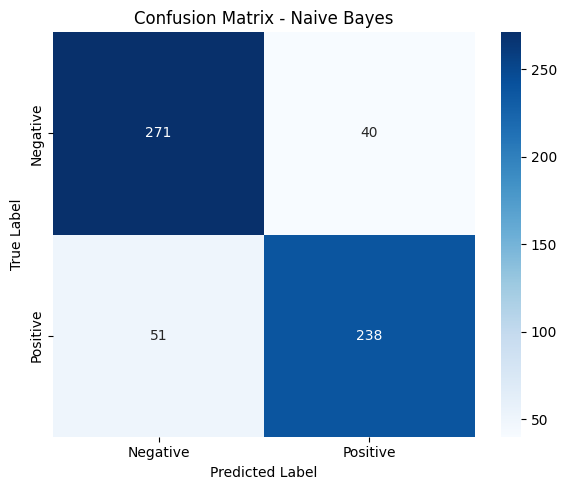


CLASSIFICATION REPORT - Naive Bayes
              precision    recall  f1-score   support

    Negative       0.84      0.87      0.86       311
    Positive       0.86      0.82      0.84       289

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

Esercizio 3 completato


In [13]:
# =========================================================
# ESERCIZIO 3: Confronto Modelli ML Classici
# =========================================================
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Subset dedicato (3000 campioni per avere risultati
# realistici ma non troppo lento)
ex3_n = 3000
ex3_X = X_train_text[:ex3_n]
ex3_y = y_train_imdb[:ex3_n]

# Split train/test
ex3_X_train, ex3_X_test, ex3_y_train, ex3_y_test = \
    train_test_split(
        ex3_X, ex3_y,
        test_size=0.2,
        random_state=42,
        stratify=ex3_y,
    )

# TF-IDF features
ex3_vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2),
    min_df=3, max_df=0.85,
)
ex3_X_train_tfidf = ex3_vectorizer.fit_transform(
    ex3_X_train
)
ex3_X_test_tfidf = ex3_vectorizer.transform(ex3_X_test)

print(f"Esercizio 3 - Train: {ex3_X_train_tfidf.shape}, "
      f"Test: {ex3_X_test_tfidf.shape}")

# Step 1: Definizione modelli
ex3_models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42,
    ),
    'Linear SVM': LinearSVC(
        random_state=42, max_iter=2000,
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42,
    ),
}

# Step 2: Training e valutazione
ex3_results = []
for name, model in ex3_models.items():
    # Train
    model.fit(ex3_X_train_tfidf, ex3_y_train)

    # Test accuracy
    y_pred = model.predict(ex3_X_test_tfidf)
    test_acc = accuracy_score(ex3_y_test, y_pred)

    # Cross-validation (5-fold)
    cv_scores = cross_val_score(
        model, ex3_X_train_tfidf, ex3_y_train, cv=5,
    )

    ex3_results.append({
        'model': name,
        'test_accuracy': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
    })

# Step 3: Risultati
ex3_results_df = pd.DataFrame(ex3_results).sort_values(
    'test_accuracy', ascending=False,
)

print("\n" + "=" * 60)
print("CONFRONTO MODELLI")
print("=" * 60)
print(ex3_results_df.to_string(index=False))

# Step 4: Confusion matrix del miglior modello
ex3_best_name = ex3_results_df.iloc[0]['model']
ex3_best_model = ex3_models[ex3_best_name]
ex3_y_pred_best = ex3_best_model.predict(ex3_X_test_tfidf)

ex3_cm = confusion_matrix(ex3_y_test, ex3_y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    ex3_cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'],
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {ex3_best_name}')
plt.tight_layout()
plt.show()

# Step 5: Report dettagliato
print("\n" + "=" * 60)
print(f"CLASSIFICATION REPORT - {ex3_best_name}")
print("=" * 60)
print(classification_report(
    ex3_y_test, ex3_y_pred_best,
    target_names=['Negative', 'Positive'],
))

print("Esercizio 3 completato")

---

# PARTE 2: NLP CON DEEP LEARNING

## 4. Word Embeddings

Gli **embeddings** rappresentano parole come vettori densi
in uno spazio continuo, catturando semantica.

### Proprieta':

- Parole simili hanno vettori vicini
- Operazioni vettoriali:
  "king" - "man" + "woman" ~ "queen"
- Dimensionalita' ridotta (50-300) vs one-hot

### 4.1 Preparazione dati per Deep Learning

In [14]:
# Parametri Deep Learning
DL_VOCAB_SIZE = 10000
DL_MAX_LENGTH = 200
DL_EMBEDDING_DIM = 100

# Subset per Deep Learning
DL_N_TRAIN = 5000
DL_N_TEST = 1000


class SimpleTokenizer:
    """Tokenizer semplice che costruisce un vocabolario."""

    def __init__(self, num_words=10000):
        self.num_words = num_words
        self.word_index = {}

    def fit_on_texts(self, texts):
        counter = Counter()
        for text in texts:
            counter.update(text.split())
        most_common = counter.most_common(
            self.num_words - 1
        )
        # Indice 0 riservato per padding
        self.word_index = {
            word: i + 1
            for i, (word, _) in enumerate(most_common)
        }

    def texts_to_sequences(self, texts):
        return [
            [
                self.word_index.get(w, 0)
                for w in text.split()
            ]
            for text in texts
        ]


def pad_sequences_manual(sequences, maxlen, padding_value=0):
    """Padding manuale delle sequenze."""
    padded = []
    for seq in sequences:
        seq = seq[:maxlen]  # Truncate
        seq = seq + [padding_value] * (maxlen - len(seq))  # Pad
        padded.append(seq)
    return np.array(padded)


# Tokenizer (fit su tutto il training set)
dl_tokenizer = SimpleTokenizer(
    num_words=DL_VOCAB_SIZE,
)
dl_tokenizer.fit_on_texts(X_train_text)

# Converti in sequenze
X_train_seq = dl_tokenizer.texts_to_sequences(
    X_train_text[:DL_N_TRAIN]
)
X_test_seq = dl_tokenizer.texts_to_sequences(
    X_test_text[:DL_N_TEST]
)

# Padding
X_train_pad = pad_sequences_manual(
    X_train_seq, maxlen=DL_MAX_LENGTH,
)
X_test_pad = pad_sequences_manual(
    X_test_seq, maxlen=DL_MAX_LENGTH,
)

y_train_dl = y_train_imdb[:DL_N_TRAIN]
y_test_dl = y_test_imdb[:DL_N_TEST]

print(f"Shape training padded: {X_train_pad.shape}")
print(f"Shape test padded: {X_test_pad.shape}")
print(f"Labels train: {len(y_train_dl)}")
print(f"Labels test: {len(y_test_dl)}")
print(f"Vocabolario: {len(dl_tokenizer.word_index)} parole")
print(f"\nEsempio sequenza (prime 20):")
print(X_train_pad[0][:20])

Shape training padded: (5000, 200)
Shape test padded: (1000, 200)
Labels train: 5000
Labels test: 1000
Vocabolario: 9999 parole

Esempio sequenza (prime 20):
[   0    6   14 1244 3727    7   10 1501    0  369  426 1349    0   50
  466   44   14 1472    0  247]


---

## 5. Recurrent Neural Networks (RNN)

Le **RNN** processano sequenze mantenendo uno "stato interno"
(memoria).

### Architettura RNN:

```
Input: x1, x2, ..., xt
       |   |        |
     [RNN] -> [RNN] -> ... -> [RNN]
       |       |               |
      h1      h2              ht
```

Ogni cell riceve input corrente $x_t$ e stato precedente
$h_{t-1}$, producendo $h_t = f(Wx_t + Uh_{t-1} + b)$.

### Problema: Vanishing Gradient

RNN semplici faticano con sequenze lunghe. **LSTM** e **GRU**
risolvono questo problema.

### 5.1 LSTM (Long Short-Term Memory)

In [ ]:
class LSTMClassifier(nn.Module):
    """Modello LSTM per sentiment analysis."""

    def __init__(
        self, vocab_size, embedding_dim, hidden_dim,
        output_dim=1, dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0,
        )
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)


def train_model(
    model, train_loader, val_loader, epochs,
    lr=0.001, patience=2,
):
    """
    Training loop PyTorch con early stopping.
    Ritorna un dizionario history compatibile.
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'loss': [], 'val_loss': [],
        'accuracy': [], 'val_accuracy': [],
    }
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch).squeeze(-1)
            loss = criterion(output, y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            predicted = (torch.sigmoid(output) > 0.5).long()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss /= total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                output = model(X_batch).squeeze(-1)
                loss = criterion(
                    output, y_batch.float(),
                )
                val_loss += loss.item() * X_batch.size(0)
                predicted = (
                    torch.sigmoid(output) > 0.5
                ).long()
                val_correct += (
                    predicted == y_batch
                ).sum().item()
                val_total += y_batch.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"loss: {train_loss:.4f} - "
            f"accuracy: {train_acc:.4f} - "
            f"val_loss: {val_loss:.4f} - "
            f"val_accuracy: {val_acc:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                k: v.cpu().clone()
                for k, v in model.state_dict().items()
            }
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(
                    f"Early stopping at epoch {epoch+1}"
                )
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)

    return history


def evaluate_model(model, test_loader):
    """Valuta accuracy su test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch).squeeze(-1)
            predicted = (
                torch.sigmoid(output) > 0.5
            ).long()
            correct += (
                predicted == y_batch
            ).sum().item()
            total += y_batch.size(0)
    return correct / total


def make_loaders(
    X_train, y_train, X_test, y_test,
    batch_size=128, val_split=0.2,
):
    """Crea DataLoader per train, val e test."""
    n_val = int(len(X_train) * val_split)
    indices = np.random.permutation(len(X_train))
    val_idx = indices[:n_val]
    train_idx = indices[n_val:]

    X_tr = torch.LongTensor(X_train[train_idx])
    y_tr = torch.LongTensor(y_train[train_idx])
    X_val = torch.LongTensor(X_train[val_idx])
    y_val = torch.LongTensor(y_train[val_idx])
    X_te = torch.LongTensor(X_test)
    y_te = torch.LongTensor(y_test)

    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=batch_size, shuffle=True,
    )
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=batch_size,
    )
    test_loader = DataLoader(
        TensorDataset(X_te, y_te),
        batch_size=batch_size,
    )
    return train_loader, val_loader, test_loader


# Creazione DataLoaders
dl_train_loader, dl_val_loader, dl_test_loader = \
    make_loaders(
        X_train_pad, y_train_dl,
        X_test_pad, y_test_dl,
        batch_size=128,
    )

# Creazione modello LSTM
model_lstm = LSTMClassifier(
    DL_VOCAB_SIZE, DL_EMBEDDING_DIM,
    hidden_dim=64,
).to(device)

print("Modello LSTM:")
print(model_lstm)
n_params = sum(
    p.numel() for p in model_lstm.parameters()
)
print(f"Parametri totali: {n_params:,}")

# Training (with pretrained weight support)
print(f"\nTraining LSTM su {len(y_train_dl)} campioni...")

history_lstm = load_or_train(
    model_lstm,
    lambda: train_model(
        model_lstm, dl_train_loader, dl_val_loader,
        epochs=10, patience=2,
    ),
    'nb06_lstm.pt',
    device=device,
)

# Valutazione
lstm_acc = evaluate_model(model_lstm, dl_test_loader)
print(f"\nLSTM Test Accuracy: {lstm_acc:.4f}")

### 5.2 Bidirectional LSTM

Processa la sequenza in entrambe le direzioni
(forward e backward) per catturare contesto completo.

In [ ]:
class BiLSTMClassifier(nn.Module):
    """LSTM bidirezionale per migliore contesto."""

    def __init__(
        self, vocab_size, embedding_dim,
        hidden_dim1=64, hidden_dim2=32,
        output_dim=1, dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0,
        )
        self.lstm1 = nn.LSTM(
            embedding_dim, hidden_dim1,
            batch_first=True, bidirectional=True,
        )
        self.lstm2 = nn.LSTM(
            hidden_dim1 * 2, hidden_dim2,
            batch_first=True, bidirectional=True,
        )
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim2 * 2, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm1_out, _ = self.lstm1(embedded)
        _, (hidden, _) = self.lstm2(lstm1_out)
        # Concatena forward e backward hidden states
        hidden = torch.cat(
            (hidden[-2], hidden[-1]), dim=1,
        )
        hidden = self.dropout1(hidden)
        hidden = self.relu(self.fc1(hidden))
        hidden = self.dropout2(hidden)
        return self.fc2(hidden)


model_bilstm = BiLSTMClassifier(
    DL_VOCAB_SIZE, DL_EMBEDDING_DIM,
).to(device)

n_params_bilstm = sum(
    p.numel() for p in model_bilstm.parameters()
)
n_params_lstm = sum(
    p.numel() for p in model_lstm.parameters()
)
print(
    f"Parametri BiLSTM: {n_params_bilstm:,}"
)
print(
    f"Parametri LSTM:   {n_params_lstm:,}"
)

# Training (with pretrained weight support)
print(f"\nTraining BiLSTM...")

history_bilstm = load_or_train(
    model_bilstm,
    lambda: train_model(
        model_bilstm, dl_train_loader, dl_val_loader,
        epochs=10, patience=2,
    ),
    'nb06_bilstm.pt',
    device=device,
)

bilstm_acc = evaluate_model(
    model_bilstm, dl_test_loader,
)
print(f"\nBiLSTM Test Accuracy: {bilstm_acc:.4f}")

### 5.3 GRU (Gated Recurrent Unit)

Variante piu' semplice di LSTM, spesso con performance
comparabili ma meno parametri.

In [17]:
class GRUClassifier(nn.Module):
    """GRU model - piu' leggero di LSTM."""

    def __init__(
        self, vocab_size, embedding_dim,
        hidden_dim1=64, hidden_dim2=32,
        output_dim=1, dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0,
        )
        self.gru1 = nn.GRU(
            embedding_dim, hidden_dim1,
            batch_first=True,
        )
        self.gru2 = nn.GRU(
            hidden_dim1, hidden_dim2,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru1_out, _ = self.gru1(embedded)
        _, hidden = self.gru2(gru1_out)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)


model_gru = GRUClassifier(
    DL_VOCAB_SIZE, DL_EMBEDDING_DIM,
).to(device)

n_params_gru = sum(
    p.numel() for p in model_gru.parameters()
)
print(f"Parametri GRU:    {n_params_gru:,}")
print(f"Parametri LSTM:   {n_params_lstm:,}")
print(f"Parametri BiLSTM: {n_params_bilstm:,}")

# Confronto tutorial
print(f"\nConfronto accuracy tutorial:")
print(f"  Logistic Regression: {acc_lr:.4f}")
print(f"  LSTM:                {lstm_acc:.4f}")
print(f"  BiLSTM:              {bilstm_acc:.4f}")

Parametri GRU:    1,041,313
Parametri LSTM:   1,042,561
Parametri BiLSTM: 1,130,689

Confronto accuracy tutorial:
  Logistic Regression: 0.8600
  LSTM:                0.5160
  BiLSTM:              0.5960


## Esercizio 4

**Task**: Costruire e confrontare LSTM, Bidirectional LSTM
e GRU su review IMDB. Visualizzare training curves e
analizzare le differenze tra architetture.

In [ ]:
# =========================================================
# ESERCIZIO 4: Confronto Architetture Deep Learning
# =========================================================

# Subset dedicato (diverso dal tutorial)
ex4_n_train = 5000
ex4_n_test = 1000

# Usiamo la seconda meta' del training set per evitare
# overlap col tutorial
ex4_start = 5000
ex4_X_train_text = X_train_text[
    ex4_start:ex4_start + ex4_n_train
]
ex4_y_train = y_train_imdb[
    ex4_start:ex4_start + ex4_n_train
]
ex4_X_test_text = X_test_text[:ex4_n_test]
ex4_y_test = y_test_imdb[:ex4_n_test]

# Tokenizzazione dedicata
ex4_vocab_size = 10000
ex4_max_length = 150
ex4_embedding_dim = 64

ex4_tokenizer = SimpleTokenizer(
    num_words=ex4_vocab_size,
)
ex4_tokenizer.fit_on_texts(ex4_X_train_text)

ex4_X_train = pad_sequences_manual(
    ex4_tokenizer.texts_to_sequences(ex4_X_train_text),
    maxlen=ex4_max_length,
)
ex4_X_test = pad_sequences_manual(
    ex4_tokenizer.texts_to_sequences(ex4_X_test_text),
    maxlen=ex4_max_length,
)

print(f"Esercizio 4 - Train: {ex4_X_train.shape}, "
      f"Test: {ex4_X_test.shape}")
print(f"Labels train: pos={sum(ex4_y_train==1)}, "
      f"neg={sum(ex4_y_train==0)}")


# Step 1: Definizione architetture
class Ex4LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.lstm = nn.LSTM(
            ex4_embedding_dim, 64, batch_first=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(self.dropout(hidden[-1]))


class Ex4BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.lstm = nn.LSTM(
            ex4_embedding_dim, 64,
            batch_first=True, bidirectional=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat(
            (hidden[-2], hidden[-1]), dim=1,
        )
        return self.fc(self.dropout(hidden))


class Ex4GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.gru = nn.GRU(
            ex4_embedding_dim, 64, batch_first=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        return self.fc(self.dropout(hidden[-1]))


ex4_models = {
    'LSTM': Ex4LSTM().to(device),
    'BiLSTM': Ex4BiLSTM().to(device),
    'GRU': Ex4GRU().to(device),
}

for name, model in ex4_models.items():
    n_p = sum(p.numel() for p in model.parameters())
    print(f"{name}: {n_p:,} parametri")

# DataLoaders per esercizio 4
ex4_train_loader, ex4_val_loader, ex4_test_loader = \
    make_loaders(
        ex4_X_train, ex4_y_train,
        ex4_X_test, ex4_y_test,
        batch_size=64,
    )

# Step 2: Training (with pretrained weight support)
ex4_histories = {}
ex4_results = []

ex4_weight_names = {
    'LSTM': 'nb06_ex4_lstm.pt',
    'BiLSTM': 'nb06_ex4_bilstm.pt',
    'GRU': 'nb06_ex4_gru.pt',
}

print("\n" + "=" * 60)
print("TRAINING MODELLI")
print("=" * 60)

for name, model in ex4_models.items():
    print(f"\nTraining {name}...")

    history = load_or_train(
        model,
        lambda m=model: train_model(
            m, ex4_train_loader, ex4_val_loader,
            epochs=10, patience=3,
        ),
        ex4_weight_names[name],
        device=device,
    )
    ex4_histories[name] = history

    test_acc = evaluate_model(
        model, ex4_test_loader,
    )
    train_acc = evaluate_model(
        model, ex4_train_loader,
    )

    n_epochs = len(history['loss']) if history is not None else 0
    ex4_results.append({
        'model': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'test_loss': history['val_loss'][-1] if history is not None else 0.0,
        'epochs': n_epochs,
    })

    print(
        f"{name} - Test: {test_acc:.4f}, "
        f"Epochs: {n_epochs}"
    )

# Step 3: Risultati
ex4_results_df = pd.DataFrame(ex4_results).sort_values(
    'test_acc', ascending=False,
)

print("\n" + "=" * 60)
print("RISULTATI FINALI")
print("=" * 60)
print(ex4_results_df.to_string(index=False))

# Step 4: Training curves
if any(h is not None for h in ex4_histories.values()):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, (name, hist) in enumerate(
        ex4_histories.items()
    ):
        ax = axes[idx]
        if hist is not None:
            ax.plot(hist['loss'], label='Train Loss')
            ax.plot(hist['val_loss'], label='Val Loss')
        else:
            ax.text(0.5, 0.5, 'Pretrained\n(no curves)',
                    ha='center', va='center',
                    transform=ax.transAxes, fontsize=12)
        ax.set_title(name)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.suptitle('Training Curves', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Using pretrained weights - training curves not available")

# Step 5: Confronto con approccio classico
print("\n" + "=" * 60)
print("CONFRONTO DL vs ML CLASSICO (tutorial)")
print("=" * 60)
print(f"Logistic Regression (TF-IDF): {acc_lr:.4f}")
for r in ex4_results:
    print(f"{r['model']:25s}: {r['test_acc']:.4f}")

print("\nEsercizio 4 completato")

---

## 6. Foundation Models per NLP

I **foundation models** sono modelli pre-trained su enormi
corpus di testo.

### Transformers e Attention

Il meccanismo di **Attention** permette al modello di
"focalizzarsi" su parti rilevanti dell'input.

### Modelli principali:

- **BERT** (Google, 2018): Bidirectional Encoder
- **GPT** (OpenAI): Generative Pre-trained Transformer
- **T5** (Google): Text-to-Text Transfer Transformer
- **RoBERTa**: BERT ottimizzato
- **DistilBERT**: BERT piu' piccolo e veloce

### 6.1 Uso di modelli pre-trained con Hugging Face

**Hugging Face** e' la libreria standard per foundation models.

In [19]:
# Installa transformers se necessario
try:
    from transformers import (
        pipeline,
        AutoTokenizer,
        AutoModelForSequenceClassification,
    )
except ImportError:
    import subprocess
    subprocess.check_call(
        ['pip', 'install', 'transformers']
    )
    from transformers import (
        pipeline,
        AutoTokenizer,
        AutoModelForSequenceClassification,
    )

print("Transformers library pronta")

2026-02-20 21:57:30.718246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Transformers library pronta


### 6.2 Sentiment Analysis con modello pre-trained

In [20]:
# Pipeline per sentiment analysis
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=(
        "distilbert-base-uncased-"
        "finetuned-sst-2-english"
    ),
    framework="pt",
)

# Test
test_texts = [
    "This movie is absolutely amazing!",
    "Worst film I've ever seen. Terrible.",
    "It was okay, nothing special.",
]

print("Predizioni con DistilBERT pre-trained:\n")
for text in test_texts:
    result = sentiment_pipeline(text)[0]
    print(f"Text: {text}")
    print(
        f"Label: {result['label']}, "
        f"Score: {result['score']:.4f}"
    )
    print()

/home/samuele/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Predizioni con DistilBERT pre-trained:

Text: This movie is absolutely amazing!
Label: POSITIVE, Score: 0.9999

Text: Worst film I've ever seen. Terrible.
Label: NEGATIVE, Score: 0.9998

Text: It was okay, nothing special.
Label: NEGATIVE, Score: 0.9821



### 6.3 Fine-tuning di BERT

Adattiamo un modello pre-trained al nostro task specifico.

> **Nota**: Il fine-tuning su CPU richiede tempo significativo
> (~25 min per 3 epoch con 1000 campioni).
> Su Google Colab, attivare il runtime GPU:
> Runtime -> Cambia tipo di runtime -> GPU

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Device configuration
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Using device: {device}")

# Caricamento modello e tokenizer
bert_model_name = "distilbert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(
    bert_model_name,
)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name, num_labels=2,
)
bert_model.to(device)

print(f"Modello: {bert_model_name}")
print(f"Parametri: {bert_model.num_parameters():,}")


# Tokenization helper
def tokenize_for_bert(texts, tokenizer, max_length=128):
    """Tokenizza testi per BERT."""
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    else:
        texts = list(texts)
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
    )


# IMPORTANTE: usiamo IMDB text + IMDB labels (matched!)
bert_n_train = 1000
bert_n_test = 200

bert_train_texts = X_train_text[:bert_n_train]
bert_train_labels = y_train_imdb[:bert_n_train]
bert_test_texts = X_test_text[:bert_n_test]
bert_test_labels = y_test_imdb[:bert_n_test]

print(
    f"Fine-tuning su {bert_n_train} campioni, "
    f"test su {bert_n_test}"
)

# Tokenize
bert_train_enc = tokenize_for_bert(
    bert_train_texts, bert_tokenizer,
)
bert_test_enc = tokenize_for_bert(
    bert_test_texts, bert_tokenizer,
)

# Labels come tensori
bert_y_train = torch.tensor(
    bert_train_labels.tolist()
    if hasattr(bert_train_labels, 'tolist')
    else list(bert_train_labels)
).long()
bert_y_test = torch.tensor(
    bert_test_labels.tolist()
    if hasattr(bert_test_labels, 'tolist')
    else list(bert_test_labels)
).long()

print(
    f"Input shape: {bert_train_enc['input_ids'].shape}"
)

# DataLoaders
bert_train_dataset = TensorDataset(
    bert_train_enc['input_ids'],
    bert_train_enc['attention_mask'],
    bert_y_train,
)
bert_test_dataset = TensorDataset(
    bert_test_enc['input_ids'],
    bert_test_enc['attention_mask'],
    bert_y_test,
)

bert_train_loader = DataLoader(
    bert_train_dataset, batch_size=16, shuffle=True,
)
bert_test_loader = DataLoader(
    bert_test_dataset, batch_size=16,
)

# Check for pretrained weights
bert_weights_path = os.path.join(WEIGHTS_DIR, 'nb06_distilbert.pt')
_bert_loaded = False

if os.path.exists(bert_weights_path):
    bert_model.load_state_dict(
        torch.load(bert_weights_path, map_location=device, weights_only=True)
    )
    print(f"Loaded pretrained DistilBERT weights from {bert_weights_path}")
    _bert_loaded = True
elif WEIGHTS_BASE_URL:
    try:
        url = WEIGHTS_BASE_URL + 'nb06_distilbert.pt'
        urllib.request.urlretrieve(url, bert_weights_path)
        bert_model.load_state_dict(
            torch.load(bert_weights_path, map_location=device, weights_only=True)
        )
        print(f"Downloaded and loaded DistilBERT weights from {url}")
        _bert_loaded = True
    except Exception as e:
        print(f"Could not download weights: {e}. Fine-tuning from scratch...")

if not _bert_loaded:
    # Optimizer
    bert_optimizer = torch.optim.Adam(
        bert_model.parameters(), lr=2e-5,
    )

    # Fine-tuning loop
    bert_epochs = 3
    bert_model.train()

    for epoch in range(bert_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress = tqdm(
            bert_train_loader,
            desc=f'Epoch {epoch + 1}/{bert_epochs}',
        )
        for batch in progress:
            input_ids, attention_mask, labels = [
                b.to(device) for b in batch
            ]

            bert_optimizer.zero_grad()

            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )

            loss = outputs.loss
            loss.backward()
            bert_optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress.set_postfix({
                'loss': f'{loss.item():.3f}',
                'acc': f'{correct/total:.3f}',
            })

        print(
            f"Epoch {epoch + 1} - "
            f"Loss: {total_loss / len(bert_train_loader):.4f}, "
            f"Accuracy: {correct / total:.4f}"
        )

    print("\nFine-tuning completato")

    # Save weights
    torch.save(bert_model.state_dict(), bert_weights_path)
    print(f"Saved DistilBERT weights to {bert_weights_path}")

# Valutazione
bert_model.eval()
bert_correct = 0
bert_total = 0

with torch.no_grad():
    for batch in bert_test_loader:
        input_ids, attention_mask, labels = [
            b.to(device) for b in batch
        ]
        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        preds = torch.argmax(outputs.logits, dim=1)
        bert_correct += (preds == labels).sum().item()
        bert_total += labels.size(0)

bert_acc = bert_correct / bert_total
print(f"BERT Fine-tuned Accuracy: {bert_acc:.4f}")

# Confronto finale
print("\n" + "=" * 60)
print("CONFRONTO FINALE (stesso test set IMDB):")
print("=" * 60)
print(f"Logistic Regression (TF-IDF): {acc_lr:.4f}")
print(f"LSTM:                         {lstm_acc:.4f}")
print(f"BiLSTM:                       {bilstm_acc:.4f}" if 'bilstm_acc' in dir() else "BiLSTM:                       N/A")
print(f"BERT fine-tuned:              {bert_acc:.4f}")

---

## 7. Utilizzo API per NLP

### 7.1 Simulazione API Hugging Face

In [22]:
class NLPAPISimulator:
    """
    Simulazione API per NLP tasks.
    In produzione useresti chiamate HTTP a:
    - Hugging Face Inference API
    - OpenAI API
    - Anthropic Claude API
    - Google Cloud Natural Language API
    """

    def __init__(self):
        self.sentiment_model = pipeline(
            "sentiment-analysis",
            model=(
                "distilbert-base-uncased-"
                "finetuned-sst-2-english"
            ),
            framework="pt",
        )

    def analyze_sentiment(self, text):
        """Analizza sentiment del testo."""
        result = self.sentiment_model(text)[0]
        return {
            'text': text,
            'sentiment': result['label'],
            'confidence': result['score'],
        }

    def batch_process(self, texts):
        """Processa batch di testi."""
        return [
            self.analyze_sentiment(t) for t in texts
        ]


# Test
nlp_api = NLPAPISimulator()

api_test_texts = [
    (
        "The cinematography was breathtaking "
        "and the acting was superb."
    ),
    (
        "Complete waste of money. "
        "Plot was confusing and boring."
    ),
    (
        "Decent movie, had some good moments "
        "but overall forgettable."
    ),
]

print("Analisi Sentiment via API:\n")
for result in nlp_api.batch_process(api_test_texts):
    print(f"Text: {result['text'][:55]}...")
    print(
        f"  -> {result['sentiment']} "
        f"({result['confidence']:.3f})"
    )
    print()

Analisi Sentiment via API:

Text: The cinematography was breathtaking and the acting was ...
  -> POSITIVE (1.000)

Text: Complete waste of money. Plot was confusing and boring....
  -> NEGATIVE (1.000)

Text: Decent movie, had some good moments but overall forgett...
  -> NEGATIVE (0.998)



### 7.2 Esempio chiamata reale API (struttura)

In [23]:
# Codice illustrativo per chiamate API reali
api_example = """
# Hugging Face Inference API
import requests

API_URL = (
    "https://api-inference.huggingface.co/models/"
    "distilbert-base-uncased-finetuned-sst-2-english"
)
headers = {"Authorization": f"Bearer {YOUR_API_KEY}"}

def query(payload):
    response = requests.post(
        API_URL, headers=headers, json=payload,
    )
    return response.json()

output = query({"inputs": "I love this product!"})

# OpenAI API
from openai import OpenAI
client = OpenAI(api_key=YOUR_API_KEY)

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system",
         "content": "You are a sentiment analyzer."},
        {"role": "user",
         "content": "Analyze: This movie is great!"},
    ],
)
print(response.choices[0].message.content)
"""

print("Struttura per API calls in produzione")
print("(vedi cella per esempi di codice)")

Struttura per API calls in produzione
(vedi cella per esempi di codice)


---

## 8. Sistema NLP Completo

Classe end-to-end che supporta approccio classico e LSTM,
dimostrando come incapsulare la pipeline.

In [ ]:
class SistemaNLPCompleto:
    """
    Sistema end-to-end per NLP.
    Supporta approccio 'classico' (TF-IDF + LR)
    e 'lstm' (embedding + LSTM).
    """

    def __init__(self, approccio='classico'):
        self.approccio = approccio
        self.model = None
        self.vectorizer = None
        self.tokenizer = None
        self.history = None
        self.max_length = 200
        self.vocab_size = 10000

    def _preprocess_classical(self, texts, fit=False):
        if fit:
            self.vectorizer = TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),
            )
            return self.vectorizer.fit_transform(texts)
        return self.vectorizer.transform(texts)

    def _preprocess_dl(self, texts, fit=False):
        if fit:
            self.tokenizer = SimpleTokenizer(
                num_words=self.vocab_size,
            )
            self.tokenizer.fit_on_texts(texts)
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences_manual(
            seqs, maxlen=self.max_length,
        )

    def build_model(self):
        """Costruisce il modello."""
        if self.approccio == 'classico':
            self.model = LogisticRegression(
                max_iter=1000, random_state=42,
            )
        elif self.approccio == 'lstm':
            self.model = LSTMClassifier(
                self.vocab_size, 100,
                hidden_dim=64,
            ).to(device)

    def train(self, X, y, epochs=5):
        """Addestra il modello."""
        if self.approccio == 'classico':
            X_proc = self._preprocess_classical(
                X, fit=True,
            )
            self.model.fit(X_proc, y)
        elif self.approccio == 'lstm':
            X_proc = self._preprocess_dl(X, fit=True)
            # Split train/val
            n_val = int(len(X_proc) * 0.2)
            indices = np.random.permutation(len(X_proc))
            val_idx = indices[:n_val]
            train_idx = indices[n_val:]

            X_tr = torch.LongTensor(X_proc[train_idx])
            y_tr = torch.LongTensor(y[train_idx])
            X_val = torch.LongTensor(X_proc[val_idx])
            y_val = torch.LongTensor(y[val_idx])

            train_loader = DataLoader(
                TensorDataset(X_tr, y_tr),
                batch_size=128, shuffle=True,
            )
            val_loader = DataLoader(
                TensorDataset(X_val, y_val),
                batch_size=128,
            )

            self.history = load_or_train(
                self.model,
                lambda: train_model(
                    self.model, train_loader, val_loader,
                    epochs=epochs, patience=2,
                ),
                'nb06_sistema_lstm.pt',
                device=device,
            )

    def evaluate(self, X, y):
        """Valuta il modello e ritorna accuracy."""
        if self.approccio == 'classico':
            X_proc = self._preprocess_classical(X)
            y_pred = self.model.predict(X_proc)
        elif self.approccio == 'lstm':
            X_proc = self._preprocess_dl(X)
            X_tensor = torch.LongTensor(X_proc)
            test_loader = DataLoader(
                TensorDataset(
                    X_tensor,
                    torch.LongTensor(y),
                ),
                batch_size=128,
            )
            return evaluate_model(
                self.model, test_loader,
            )

        acc = accuracy_score(y, y_pred)
        return acc

    def predict_text(self, text):
        """Predice sentiment di un singolo testo."""
        if self.approccio == 'classico':
            X_proc = self._preprocess_classical([text])
            pred = self.model.predict(X_proc)[0]
            prob = self.model.predict_proba(X_proc)[0]
            return {
                'sentiment': (
                    'Positive' if pred == 1
                    else 'Negative'
                ),
                'confidence': float(prob[pred]),
            }
        elif self.approccio == 'lstm':
            X_proc = self._preprocess_dl([text])
            X_tensor = torch.LongTensor(
                X_proc
            ).to(device)
            self.model.eval()
            with torch.no_grad():
                output = self.model(
                    X_tensor
                ).squeeze(-1)
                pred_val = torch.sigmoid(
                    output
                ).item()
            pred_class = 1 if pred_val > 0.5 else 0
            return {
                'sentiment': (
                    'Positive' if pred_class == 1
                    else 'Negative'
                ),
                'confidence': (
                    pred_val if pred_class == 1
                    else 1 - pred_val
                ),
            }


# ---- Test del sistema ----

# Dati IMDB consistenti
sys_n_train = 3000
sys_n_test = 500
sys_X_train = X_train_text[:sys_n_train]
sys_y_train = y_train_imdb[:sys_n_train]
sys_X_test = X_test_text[:sys_n_test]
sys_y_test = y_test_imdb[:sys_n_test]

print("Test Sistema NLP Completo:")
print(
    f"Train: {sys_n_train}, "
    f"Test: {sys_n_test}\n"
)

# Test classico
print("--- Approccio Classico ---")
sistema_classico = SistemaNLPCompleto('classico')
sistema_classico.build_model()
sistema_classico.train(sys_X_train, sys_y_train)
acc_classico = sistema_classico.evaluate(
    sys_X_test, sys_y_test,
)
print(f"Accuracy: {acc_classico:.4f}\n")

# Test LSTM
print("--- Approccio LSTM ---")
sistema_lstm = SistemaNLPCompleto('lstm')
sistema_lstm.build_model()
sistema_lstm.train(
    sys_X_train, sys_y_train, epochs=5,
)
acc_lstm_sys = sistema_lstm.evaluate(
    sys_X_test, sys_y_test,
)
print(f"Accuracy: {acc_lstm_sys:.4f}\n")

# Confronto
print("=" * 40)
print("RISULTATI:")
print("=" * 40)
print(f"Classico (TF-IDF + LR): {acc_classico:.4f}")
print(f"LSTM:                   {acc_lstm_sys:.4f}")

# Test su testo singolo
print("\n--- Predizione singola ---")
test_text = "This movie was really great and fun!"
for name, sistema in [
    ('Classico', sistema_classico),
    ('LSTM', sistema_lstm),
]:
    result = sistema.predict_text(test_text)
    print(
        f"{name}: {result['sentiment']} "
        f"({result['confidence']:.3f})"
    )

---

## Conclusioni

### Approccio Classico:

- Preprocessing: tokenization, stopwords,
  stemming/lemmatization
- Feature extraction: BOW, TF-IDF
- Classificatori: Naive Bayes, Logistic Regression,
  SVM, Random Forest
- Analisi feature importance

### Deep Learning:

- Word Embeddings: rappresentazioni dense
- RNN/LSTM/GRU: architetture per sequenze
- Bidirectional LSTM: contesto completo
- Foundation Models: BERT, DistilBERT
- Fine-tuning: adattamento task-specific
- API: deployment e usage

### Concetti Chiave

1. **Preprocessing e' fondamentale**: la qualita'
   del preprocessing determina il successo
2. **TF-IDF > BOW**: per la maggior parte dei task
3. **LSTM/GRU per sequenze**: gestiscono dipendenze
   a lungo termine
4. **Foundation models sono il futuro**: transfer
   learning e' standard
5. **Fine-tuning > training da zero**: specialmente
   con dati limitati
6. **Context matters**: modelli bidirezionali catturano
   meglio il significato

### Workflow Consigliato

1. **Baseline veloce**: TF-IDF + Logistic Regression
2. **Se serve piu' accuracy**: prova LSTM/GRU
3. **Per performance SOTA**: fine-tune BERT/DistilBERT
4. **In produzione**: valuta costo/beneficio di ogni
   approccio